In [14]:
import sys

import torch

sys.path.append("../")
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from lib.datasets import HomogeneousPipelineDataset
from lib.models import HomogeneousGCN
from lib.pl import LightningModule
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
model = LightningModule.load_from_checkpoint(
    r"C:\Users\Konstantin\PycharmProjects\NIR\experiments\homogeneous_gcn\pipeline_dataset\g3_8__m2_8__sum_agg__clip__lr_0.001__edge_direction_undirected__no_operations_hyperparameters\version_0\checkpoints\last.ckpt",
    model=HomogeneousGCN(
        in_channels=15,
        out_channels=2,
        gnn_num_layers=3,
        gnn_hidden_channels=8,
        mlp_num_layers=2,
        mlp_hidden_channels=8,
        aggregation="sum",
        clip_output=(0., 1.)
    ),
    loss=F.mse_loss,
    lr=1e-3,
    )
model = model.eval()

In [19]:
dataset = HomogeneousPipelineDataset(
    root=r"C:\Users\Konstantin\PycharmProjects\NIR\notebooks\ranking_data",
    split=None,
    direction="undirected",
    use_operations_hyperparameters=False,
)
loader = DataLoader(
    dataset,
    batch_size=1024,
    shuffle=False,
)

In [20]:
preds = []
fitness = []
for batch in iter(loader):
    x, fitness_value = batch
    with torch.no_grad():
        pred = model.model(x).numpy()
    pred_scaled_back = dataset._metrics_scaler.inverse_transform(pred)
    fitness_scaled_back = dataset._metrics_scaler.inverse_transform(fitness_value)
    fitness.append(fitness_scaled_back)
    preds.append(pred_scaled_back)

In [21]:
pred_roc_auc, pred_f1 = np.vstack(preds).T
fitness, filler = np.vstack(fitness).T

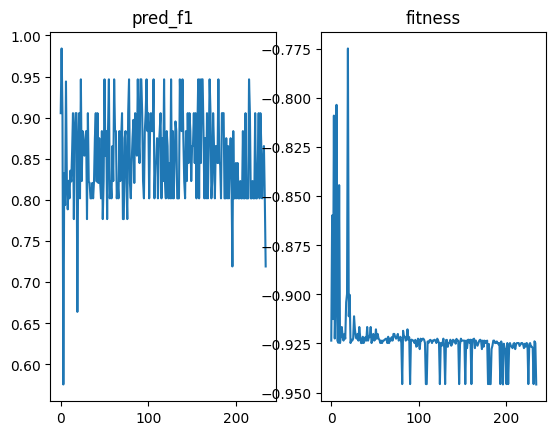

In [60]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(pred_f1)
ax[0].set_title("pred_f1")
ax[1].plot(fitness)
ax[1].set_title("fitness")
plt.show()

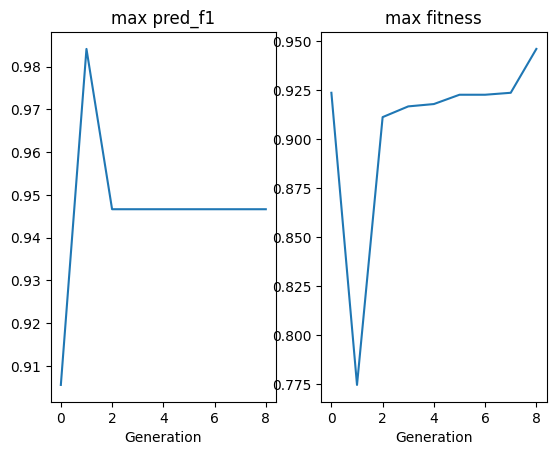

In [68]:
with open(r"C:\Users\Konstantin\PycharmProjects\NIR\notebooks\history.pickle", "rb") as f:
    history = pickle.load(f)
idxes = list(map(len, history.historical_fitness))
temp = []
for i in range(len(idxes)):
    if i == 0:
        start = 0
    else:
        start = idxes[i-1]
    stop = idxes[i] + start
    mean_value = pred_f1[start: stop].max()
    temp.append(mean_value)
fig, ax = plt.subplots(1, 2)
ax[0].plot(temp)
ax[0].set_title("max pred_f1")
ax[0].set_xlabel("Generation")
ax[1].plot(list(map(lambda x: -1 * np.max(x), history.historical_fitness)))
ax[1].set_title("max fitness")
ax[1].set_xlabel("Generation")
plt.show()

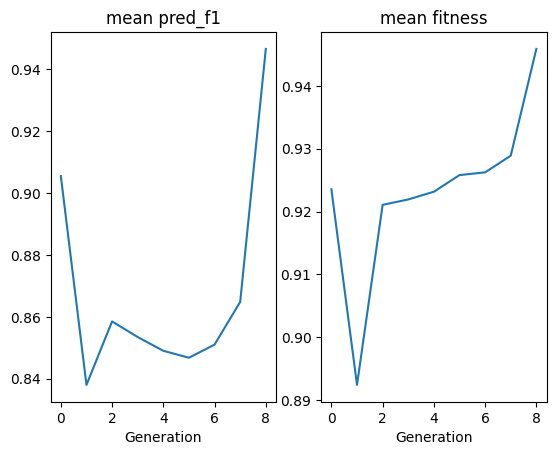

In [69]:
with open(r"C:\Users\Konstantin\PycharmProjects\NIR\notebooks\history.pickle", "rb") as f:
    history = pickle.load(f)
idxes = list(map(len, history.historical_fitness))
temp = []
for i in range(len(idxes)):
    if i == 0:
        start = 0
    else:
        start = idxes[i-1]
    stop = idxes[i] + start
    mean_value = pred_f1[start: stop].mean()
    temp.append(mean_value)
fig, ax = plt.subplots(1, 2)
ax[0].plot(temp)
ax[0].set_title("mean pred_f1")
ax[0].set_xlabel("Generation")
ax[1].plot(list(map(lambda x: -1 * np.mean(x), history.historical_fitness)))
ax[1].set_title("mean fitness")
ax[1].set_xlabel("Generation")
plt.show()

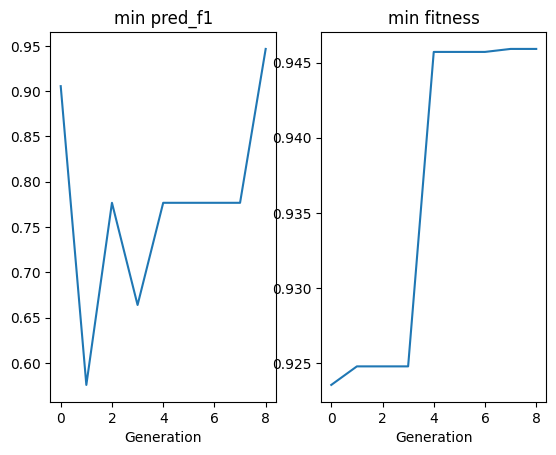

In [70]:
with open(r"C:\Users\Konstantin\PycharmProjects\NIR\notebooks\history.pickle", "rb") as f:
    history = pickle.load(f)
idxes = list(map(len, history.historical_fitness))
temp = []
for i in range(len(idxes)):
    if i == 0:
        start = 0
    else:
        start = idxes[i-1]
    stop = idxes[i] + start
    mean_value = pred_f1[start: stop].min()
    temp.append(mean_value)
fig, ax = plt.subplots(1, 2)
ax[0].plot(temp)
ax[0].set_title("min pred_f1")
ax[0].set_xlabel("Generation")
ax[1].plot(list(map(lambda x: -np.min(x), history.historical_fitness)))
ax[1].set_title("min fitness")
ax[1].set_xlabel("Generation")
plt.show()

2023-03-30 05:00:50,045 - FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


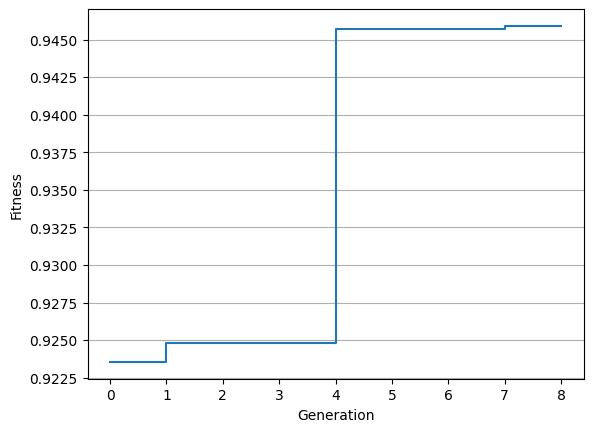

In [54]:
history.show()

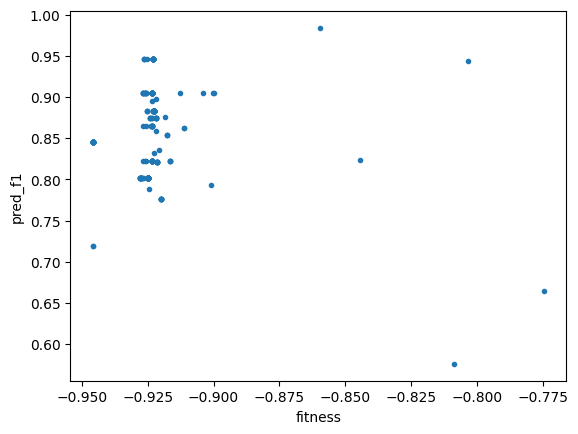

In [45]:
plt.plot(fitness, pred_f1, ls="", marker=".")
plt.xlabel("fitness")
plt.ylabel("pred_f1")
plt.show()

In [26]:
roc_auc_ranking = np.argsort(pred_roc_auc)
f1_ranking = np.argsort(pred_f1)
fitness_ranking = np.argsort(fitness)

In [38]:
# # plt.plot(roc_auc_ranking, label="roc_auc_ranking")
# plt.plot(f1_ranking, fitness_ranking, label="f1_ranking")
# # plt.plot(fitness_ranking, label="fitness_ranking")
# # plt.legend()
# plt.show()

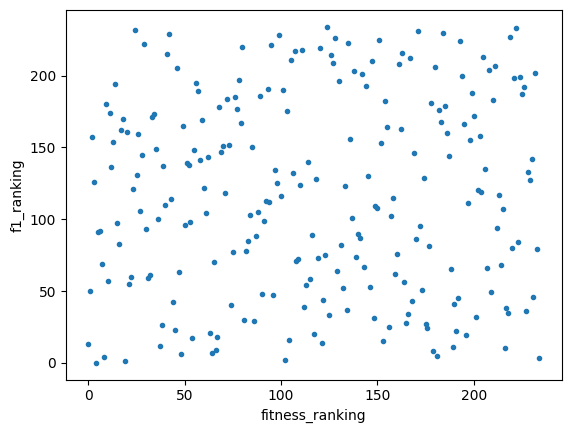

In [41]:
plt.plot(fitness_ranking, f1_ranking, label="f1_ranking", ls="", marker=".")
plt.xlabel("fitness_ranking")
plt.ylabel("f1_ranking")
plt.show()